
# Improving Computer Vision Accuracy using Convolutions

In the previous lessons you saw how to do fashion recognition using a Deep Neural Network (DNN) containing three layers -- the input layer (in the shape of the data), the output layer (in the shape of the desired output) and a hidden layer.

Here, we will use convolutions to improve the accuracy of the predictions. 

## Import Libraries
Let's start with our import of pytorch (torch), numpy, and skimage for transforming the image.

In [4]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import os

## Provide Data
For the data, we will be using Fashion MNIST ( https://github.com/zalandoresearch/fashion-mnist ), consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes/ types of clothes. The dataset is available from the torchvision library, which consists of popular datasets, model architectures, and common image transformations for computer vision.. You load it like this:

In [5]:
# Transform could also use the mean and standard deviation of all the pixels in the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.FashionMNIST('/scratch/{}/F_MNIST_data/'.format(os.environ['USER']), download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('/scratch/{}/F_MNIST_data/'.format(os.environ['USER']), download=True, train=False, transform=transform)
batch_size=1024   # Reduce if out-of-memory error
trainloader = DataLoader(trainset,batch_size=batch_size, shuffle=True,num_workers=int(os.environ['SLURM_CPUS_PER_TASK']))
testloader = DataLoader(testset,batch_size=batch_size, shuffle=True,num_workers=int(os.environ['SLURM_CPUS_PER_TASK']))

Label for image is 9


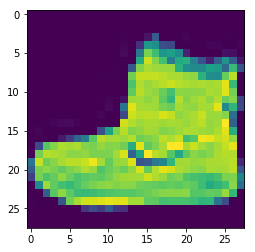

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
img_index=0
img = trainset[img_index][0].numpy()
plt.imshow(img.reshape(28,28))
label = trainset[img_index][1]
print("Label for image is {}".format(label))

## Define and Compile the Neural Network
Let's now design the model. Things to note:

Linear Module (**nn.Linear**) computes output from input using a linear function, and holds internal Tensors for its weight and bias.

Each layer of neurons need an activation function to tell them what to do. There's lots of options, but just use these for now.

**Relu** effectively means "If X>0 return X, else return 0" -- so what it does it it only passes values 0 or greater to the next layer in the network.

**Softmax** takes a set of values, and effectively picks the biggest one, so, for example, if the output of the last layer looks like [0.1, 0.1, 0.05, 0.1, 9.5, 0.1, 0.05, 0.05, 0.05], it saves you from fishing through it looking for the biggest value, and turns it into [0,0,0,0,1,0,0,0,0] -- The goal is to save a lot of coding!

Here, we create a nn.Module class named Net. The init function (defines input and number of neurons) and forward function (where the network makes a guess) are defined and the backward function (where gradients are computed) is automatically defined using autograd.

Once the model is defined, we instantiate the model passing in .cuda if using the GPU.

In [7]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        # which is what we are using.
        
        # Convolution Layer 1                             # 28 x 28 x 1  (input)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)      # 26 x 26 x 64  (after 1st convolution)
        self.maxpool1 = nn.MaxPool2d(2)                   # 13 x 13 x 64
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(64,64, kernel_size=3)     # 11 x 11 x 64 (after 2nd convolution)
        self.maxpool2 = nn.MaxPool2d(2)                   # 5 x 5 x 64  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 1600)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

In [9]:
# The model
net = CNN()   #instantiate the model

if torch.cuda.is_available():
    net = net.cuda()      # pass model to GPU device

print(net) 
# Our loss function
criterion = nn.CrossEntropyLoss()    # define loss

# Our optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)    # define optimizer

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
num_epochs = 5

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    net.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(trainloader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
            
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = net(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
#        iter_loss += loss.data[0] # Accumulate the loss
        iter_loss += loss.item() 
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100.0 * correct.cpu().numpy() / len(trainloader.dataset)))    # use numpy otherwise rounded up
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    net.eval()                    # Put the network into evaluate mode
    
    for i, (items, classes) in enumerate(testloader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = net(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    valid_accuracy.append(100.0 * correct.cpu().numpy() / len(testloader.dataset))

    
    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/5, Tr Loss: 0.9983, Tr Acc: 64.8133, Val Loss: 0.5725, Val Acc: 78.9000
Epoch 2/5, Tr Loss: 0.4807, Tr Acc: 82.2667, Val Loss: 0.4542, Val Acc: 83.3900
Epoch 3/5, Tr Loss: 0.4172, Tr Acc: 84.6967, Val Loss: 0.4354, Val Acc: 84.2300
Epoch 4/5, Tr Loss: 0.3785, Tr Acc: 86.1900, Val Loss: 0.4011, Val Acc: 85.1200
Epoch 5/5, Tr Loss: 0.3602, Tr Acc: 86.7917, Val Loss: 0.3800, Val Acc: 86.0400


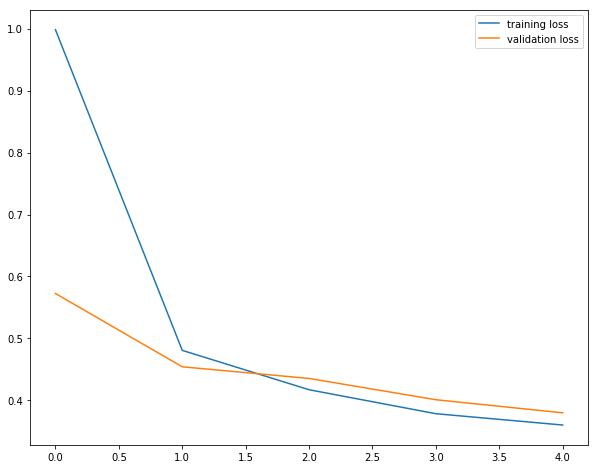

In [11]:
f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()